<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03/MSDS458_Assignment_03_Experiment_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiments C: LSTM: 
Try several experiments by tweaking (i) architecture (ii) Bidirectional/unidirectional & other hyper parameters, including regularization.

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load Package

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-19 07:46:22.930795: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0219 07:46:22.931579 140616180631424 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0219 07:46:23.555259 140616180631424 dataset_info.py:434] Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
I0219 07:46:24.523177 140616180631424 dataset_info.py:361] Load dataset info from /tmp/tmp1xb2qr3mtfds
I0219 07:46:24.525441 140616180631424 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0219 07:46:24.525929 140616180631424 dataset_builder.py:357] Generating dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]I0219 07:46:25.158340 140616180631424 download_manager.py:476] 

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Explore Vocab

In [5]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

### Compile, Train Model

In [6]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [7]:
import datetime as dt

def compile_train_model(model, epoch):
  #compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

## LSTM

### Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary());

In [9]:
corpus, doc_sizes = explore_vocab(train_dataset,encoder)

In [10]:
vocab = np.array(encoder.get_vocabulary())
num_vocab_words_in_corpus =len(vocab)

num_words =len(corpus)
num_articles =len(doc_sizes)
min_token_in_a_article = min(doc_sizes)
max_token_in_a_article = max(doc_sizes)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

1000
114000
18
5200
6400


### Create Model

In [11]:
LSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.LSTM(units = 64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])


In [12]:
Multiplelayer_LSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.LSTM(units = 64, return_sequences=True)                              
                              ,tf.keras.layers.LSTM(units = 64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [13]:
BidirectionalLSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)) 
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [14]:
Multiplelayer_BidirectionalLSTM = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

In [15]:
Multiplelayer_BidirectionalLSTM_Dropout = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, recurrent_dropout=0.25))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)                              
                              ,tf.keras.layers.Dense(4,activation='softmax')   # num_classes = 4
])

Recurrent dropout—This is a variant of dropout, used to fight overfitting in recurrent layers.
Stacking recurrent layers—This increases the representational power of the model (at the cost of higher computational loads).
Bidirectional recurrent layers—These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.

### LSTM

Epoch 1/2
18/18 [==============================] - 174s 9s/step - loss: 1.3856 - accuracy: 0.3004 - val_loss: 1.3846 - val_accuracy: 0.3425
Epoch 2/2
2/2 [==============================] - 3s 507ms/step - loss: 1.3823 - accuracy: 0.3892
test set accuracy:  38.92105221748352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

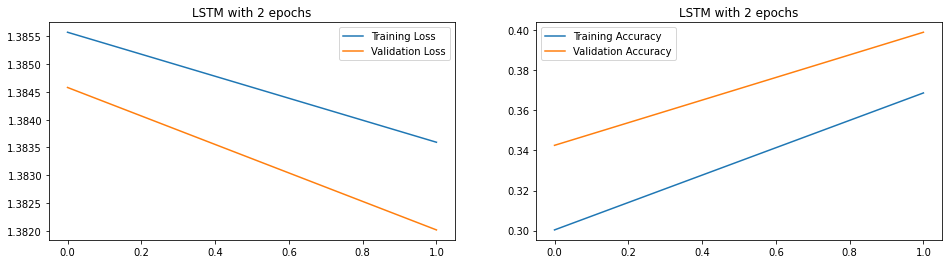

In [16]:
result_LSTM = compile_train_model(LSTM, 200)

In [17]:
result_LSTM['vocab_size'] = VOCAB_SIZE 
result_LSTM['num_words'] = num_words 
result_LSTM['num_articles'] = num_articles
result_LSTM['min_token_in_a_article'] = min_token_in_a_article 
result_LSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['LSTM']   
result_LSTM.insert(loc=0, column='Model', value=new_col)

In [18]:
prev_results_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/resultsB.pkl')
assignment_result_table = prev_results_df.append(result_LSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


### Multiplelayer LSTM

Epoch 1/2
18/18 [==============================] - 299s 16s/step - loss: 1.3857 - accuracy: 0.3143 - val_loss: 1.3847 - val_accuracy: 0.3595
Epoch 2/2
2/2 [==============================] - 6s 1s/step - loss: 1.3814 - accuracy: 0.4347
test set accuracy:  43.473684787750244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

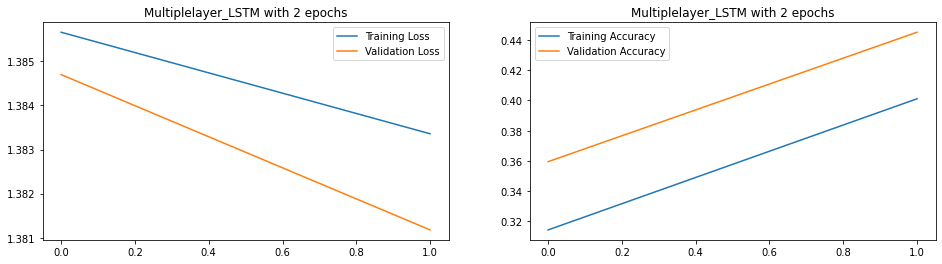

In [19]:
result_mLSTM = compile_train_model(Multiplelayer_LSTM, 200)

In [21]:
result_mLSTM['vocab_size'] = VOCAB_SIZE 
result_mLSTM['num_words'] = num_words 
result_mLSTM['num_articles'] = num_articles
result_mLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_mLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer LSTM']   
result_mLSTM.insert(loc=0, column='Model', value=new_col)

In [22]:
assignment_result_table = assignment_result_table.append(result_mLSTM,ignore_index=True)
assignment_result_table

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
0,RNN with 1000 vocab size,0.377154,0.863553,0.388227,0.862333,0.400026,0.853684,2233.756780,200,8,1000,114000,1782,16,64
1,RNN with 2000 vocab size,0.291024,0.896395,0.350998,0.874000,0.355715,0.872105,3211.853945,200,12,2000,114000,1782,16,64
2,RNN with 3000 vocab size,0.267700,0.904658,0.322919,0.886833,0.329175,0.884342,1899.668785,200,7,3000,114000,1782,16,64
3,RNN with filtered vocab that deleting the most...,0.377646,0.860895,0.392394,0.856833,0.403119,0.847763,2881.808089,200,11,898,114000,1782,16,64
4,RNN with 1000 vocab size 50 output sequence le...,0.367516,0.866158,0.391233,0.860333,0.399400,0.853026,2606.611799,200,13,1000,114000,1782,16,64
5,SimpleRNN,0.374977,0.865956,0.400744,0.855167,0.420890,0.850526,682.234513,200,9,1000,114000,1782,16,64
6,Multiplelayer RNN,0.362619,0.869114,0.401836,0.855833,0.422530,0.849474,1086.008980,200,8,1000,114000,1782,16,64
7,Bidirectional RNN,0.362689,0.867842,0.387893,0.861833,0.405440,0.851842,797.343860,200,6,1000,114000,1782,16,64
8,Multiplelayer Bidirectional RNN,0.378119,0.863360,0.411663,0.856667,0.431394,0.844868,708.051660,200,3,1000,114000,1782,16,64
9,Multiplelayer Bidirectional RNN with Dropout,0.409446,0.859158,0.394270,0.862667,0.414101,0.850132,2583.185984,200,10,1000,114000,1782,16,64


### Bidirectional LSTM

In [24]:
result_BiLSTM = compile_train_model(BidirectionalLSTM, 200)

Epoch 1/2
18/18 [==============================] - 289s 15s/step - loss: 1.3845 - accuracy: 0.2721 - val_loss: 1.3825 - val_accuracy: 0.3078
Epoch 2/2
 3/18 [====>.........................] - ETA: 3:44 - loss: 1.3826 - accuracy: 0.2995

KeyboardInterrupt: ignored

In [ ]:
result_BiLSTM['vocab_size'] = VOCAB_SIZE 
result_BiLSTM['num_words'] = num_words 
result_BiLSTM['num_articles'] = num_articles
result_BiLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_BiLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Bidirectional LSTM']   
result_BiLSTM.insert(loc=0, column='Model', value=new_col)

In [ ]:
assignment_result_table = assignment_result_table.append(result_BiLSTM,ignore_index=True)
assignment_result_table

### Multiplelayer Bidirectional LSTM

In [ ]:
result_MBiLSTM = compile_train_model(Multiplelayer_BidirectionalLSTM, 200)

In [ ]:
result_MBiLSTM['vocab_size'] = VOCAB_SIZE 
result_MBiLSTM['num_words'] = num_words 
result_MBiLSTM['num_articles'] = num_articles
result_MBiLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_MBiLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer Bidirectional LSTM']   
result_MBiLSTM.insert(loc=0, column='Model', value=new_col)

In [ ]:
assignment_result_table = assignment_result_table.append(result_MBiLSTM,ignore_index=True)
assignment_result_table

### Multiplelayer Bidirectional LSTM Dropout

In [ ]:
result_MBiDLSTM = compile_train_model(Multiplelayer_BidirectionalLSTM_Dropout, 200)

In [ ]:
result_MBiDLSTM['vocab_size'] = VOCAB_SIZE 
result_MBiDLSTM['num_words'] = num_words 
result_MBiDLSTM['num_articles'] = num_articles
result_MBiDLSTM['min_token_in_a_article'] = min_token_in_a_article 
result_MBiDLSTM['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['Multiplelayer Bidirectional LSTM with Dropout']   
result_MBiDLSTM.insert(loc=0, column='Model', value=new_col)

In [ ]:
assignment_result_table = assignment_result_table.append(result_MBiDLSTM,ignore_index=True)
assignment_result_table

## Save data

In [ ]:
assignment_result_table.to_pickle("/content/gdrive/My Drive/Colab Notebooks/resultsC.pkl") 
assignment_result_table.to_csv("/content/gdrive/My Drive/Colab Notebooks/resultsC.csv") 